In [2]:
!export GEOMSTATS_BACKEND=torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.learning.frechet_mean import FrechetMean

from tqdm import tqdm

INFO:root:Using numpy backend


In [3]:
CUTOFFS = [99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]
EMBED_DIM = 128
N_SAMPLES = 1000 # Cut off so that MOMS and T2D are manageable to run

EMBED_PATH = f"data/{EMBED_DIM}d_hyperbolic_otu_embeddings.csv"
HYPERBOLIC = True
MAX_ITER = 1000 # For Frechet mean

In [4]:
data = {"ibd": {}, "moms": {}, "t2d": {}}
embedded_data = {"ibd": {}, "moms": {}, "t2d": {}}

embeddings = pd.read_csv(
    EMBED_PATH, dtype={0: str}
)
embeddings = embeddings.set_index(embeddings.columns[0])

# Now populate the data dict
for name in ["ibd", "moms", "t2d"]:
# for name in ["t2d"]:
# for name in ["ibd"]:
    for cutoff in CUTOFFS:
        df = pd.read_csv(
            f"/home/phil/phylosig/ihmp/clustered/{name}/otus_{cutoff}.csv",
            index_col=["site", "patient", "visit", "sample"],
        )

        # This matrix multiplication does the weighted sum for us, if our
        # data is normalized - in this case it already is

        data[name][cutoff] = df
        embed = embeddings.reindex(df.columns)

        # Reindex the embeddings to match the columns of the dataframe
        if HYPERBOLIC:
            dim = embeddings.shape[1]
            hyp = Hyperbolic(dim=dim, default_coords_type="ball")
            fmean = FrechetMean(hyp.metric, max_iter=MAX_ITER)

            mixture_embeddings = np.zeros((df.shape[0], dim))
            for i, sample in tqdm(
                enumerate(df.index[:N_SAMPLES]), 
                total=np.min(df.shape[0], N_SAMPLES)
            ):
                mixture_embeddings[i] = fmean.fit(
                    embed,
                    weights=df.loc[sample].values
                ).estimate_

            embedded_data[name][cutoff] = mixture_embeddings
        else:
            embedded_data[name][cutoff] = df @ embed


 43%|████▎     | 1000/2304 [00:01<00:01, 990.58it/s]


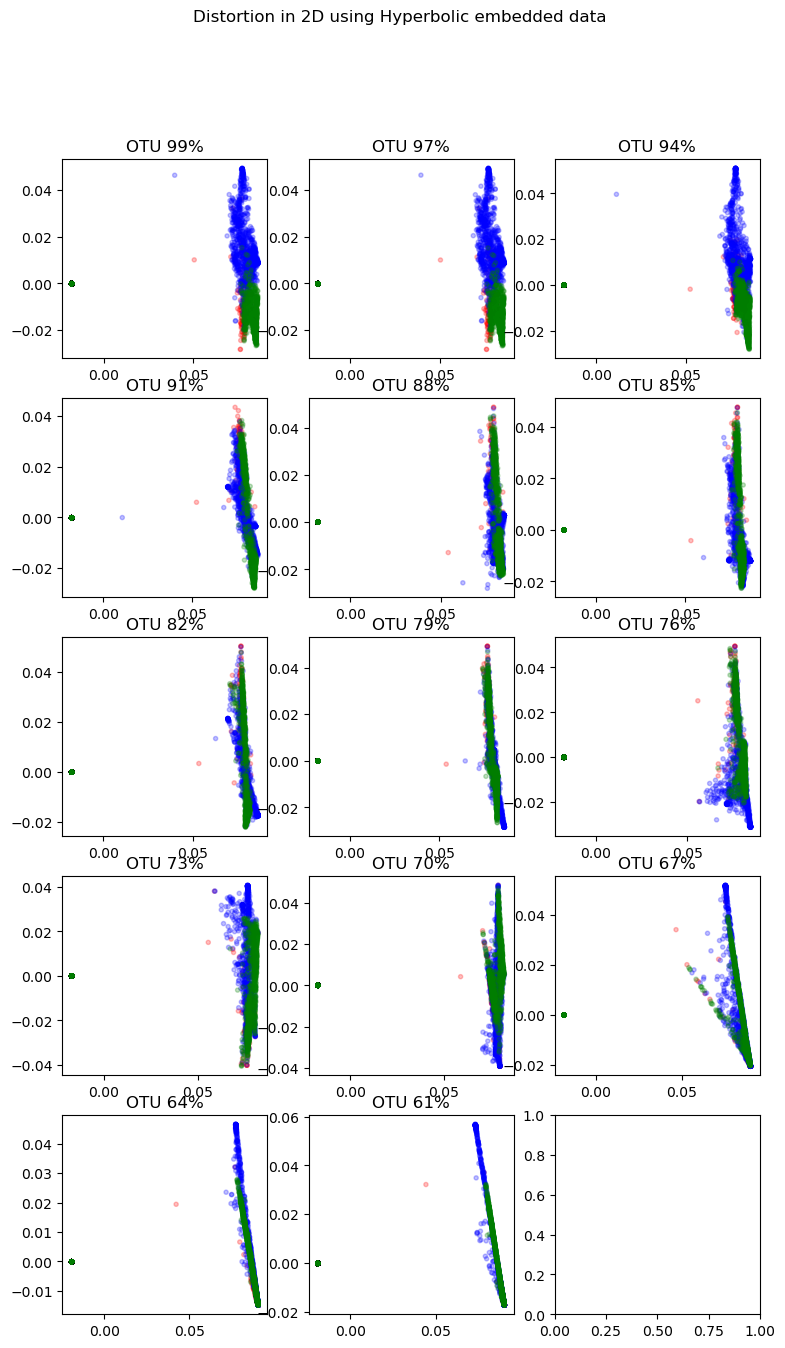

In [5]:
# Plot data with PCA in 2-d

def plot_pca(data_dict, title):
    fig, axs = plt.subplots(5, 3, figsize=(9, 15))
    labels = (
        ["red"] * len(data_dict["ibd"][99])
        + ["blue"] * len(data_dict["moms"][99])
        + ["green"] * len(data_dict["t2d"][99])
    )

    for i, size in enumerate(CUTOFFS):
        df = np.vstack(
            [data_dict[name][size] for name in ["ibd", "moms", "t2d"]]
        )
        # Get the PCA
        pca = PCA(n_components=2)
        pca.fit(df)
        # Transform the data
        transformed = pca.transform(df)
        # Plot the data
        axs[i // 3, i % 3].scatter(
            transformed[:, 0],
            transformed[:, 1],
            c=labels,
            s=9,
            alpha=0.25
        )
        axs[i // 3, i % 3].set_title(f"OTU {size}%")
        # axs[i // 3, i % 3].legend()

    plt.suptitle(title)
    plt.show()

plot_pca(data, "Distortion in 2D using raw data")


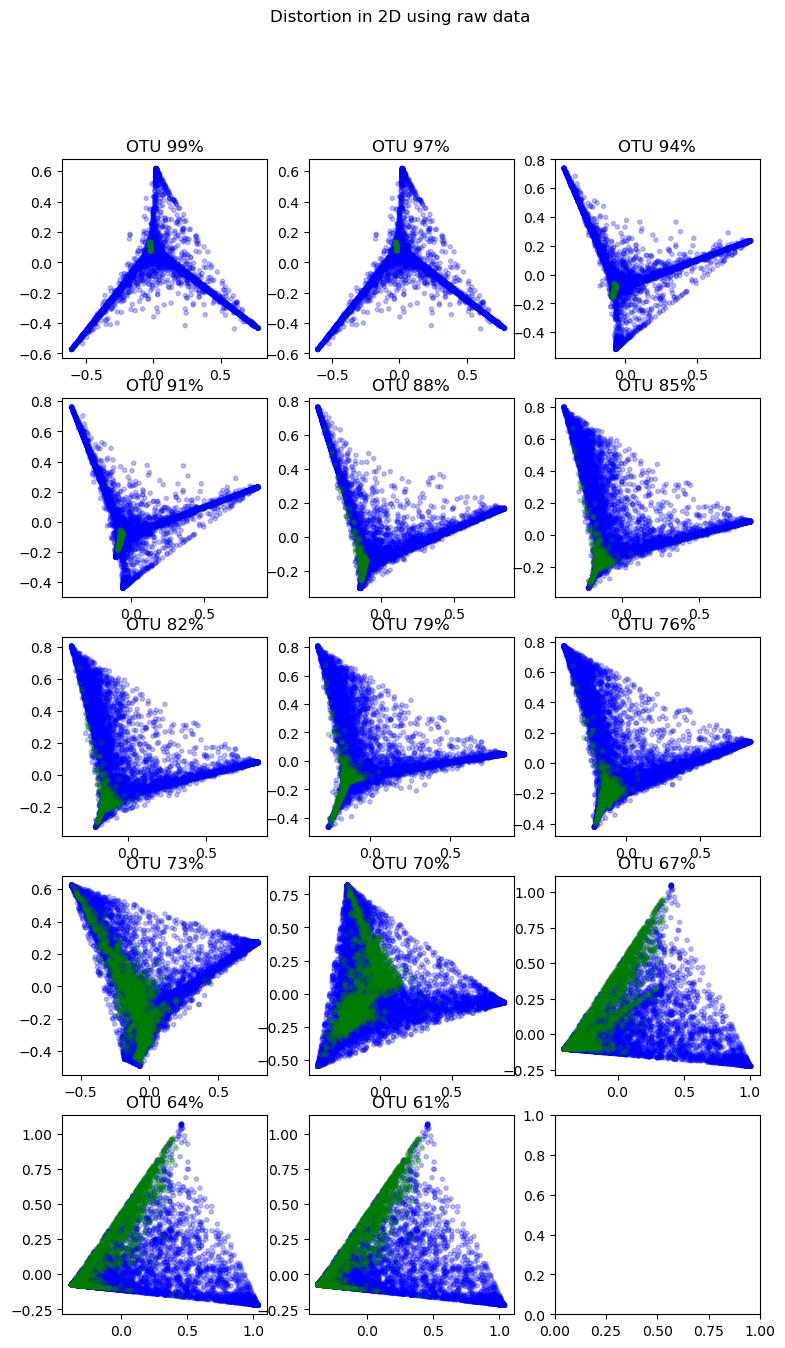

In [6]:
# # Plot data with PCA in 2-d

# fig, axs = plt.subplots(5, 3, figsize=(9, 15))

# for i, size in enumerate(CUTOFFS):
#     df = pd.concat(
#         [data[name][size] for name in ["ibd", "moms", "t2d"]]
#     ).fillna(0)
#     # Get the PCA
#     pca = PCA(n_components=2)
#     pca.fit(df)
#     # Transform the data
#     transformed = pca.transform(df)
#     # Plot the data
#     axs[i // 3, i % 3].scatter(
#         transformed[:, 0],
#         transformed[:, 1],
#         c=labels,
#         s=9,
#         alpha=0.25
#     )
#     axs[i // 3, i % 3].set_title(f"OTU {size}%")
#     # axs[i // 3, i % 3].legend()

# plt.suptitle("Distortion in 2D using raw data")
# plt.show()

plot_pca(embedded_data, "Distortion in 2D using hyperbolic embeddings")

In [7]:
# Measure distortion in pairwise distances between samples
# Using efficient pairwise distance calculation

N_SAMPLES = 1000

from scipy.spatial.distance import pdist, squareform
from geomstats.geometry.hyperbolic import Hyperbolic

hyp = Hyperbolic(dim=128, default_coords_type="ball")

dists = {"ibd": {}, "moms": {}, "t2d": {}}
pca_dists = {"ibd": {}, "moms": {}, "t2d": {}}
embed_dists = {"ibd": {}, "moms": {}, "t2d": {}}
# embed_euc = {"ibd": {}, "moms": {}, "t2d": {}}

def clr(x, eps=1e-10):
    """Centered log-ratio transform: log(x / geom_mean(x))"""
    # return np.log(x / geom_mean(x))
    x = np.array(x) + eps
    if x.ndim == 1:
        return np.log(x) - np.log(x).mean()
    else:
        return np.log(x) - np.log(x).mean(axis=1, keepdims=True)

def aitchison(x, y):
    """Aitchison distance between two vectors"""
    if x.ndim == 1:
        return np.linalg.norm(clr(x) - clr(y))
    else:
        return np.linalg.norm(clr(x) - clr(y), axis=1)

for name in ["ibd", "moms", "t2d"]:
# for name in ["moms"]:
# for name in ["t2d"]:
    pca_dists[name] = {x: {} for x in CUTOFFS}
    for cutoff in tqdm(CUTOFFS):

        dists[name][cutoff] = squareform(
            # pdist(data[name][cutoff].iloc[:N_SAMPLES], metric="euclidean")
            pdist(clr(data[name][cutoff].iloc[:N_SAMPLES]), metric="euclidean")
        )

        if data[name][cutoff].shape[1] > 16:
            pca_dists[name][cutoff] = squareform(
                pdist(
                    PCA(n_components=16).fit_transform(
                        clr(data[name][cutoff].iloc[:N_SAMPLES])
                    ), 
                    metric="euclidean")
            )
        else:
            pca_dists[name][cutoff] = dists[name][cutoff]

        embed_dists[name][cutoff] = squareform(
            pdist(embedded_data[name][cutoff][:N_SAMPLES], metric=hyp._metric.dist)
            # pdist(clr(embedded_data[name][cutoff][:N_SAMPLES]), metric="euclidean")
        )

        # embed_euc[name][cutoff] = squareform(
        #     # pdist(embedded_data[name][cutoff][:N_SAMPLES], metric="euclidean")
        #     pdist(embedded_data[name][cutoff][:N_SAMPLES], metric=aitchison)
        # )

100%|██████████| 14/14 [04:50<00:00, 20.78s/it]


In [1]:
print(pca_dists)

NameError: name 'pca_dists' is not defined

In [8]:
clr(data["ibd"][99].iloc[0])

array([ 6.11201359, -4.11550216, -4.11550216, ..., -4.11550216,
        7.49828083, -4.11550216])

In [9]:
# Compute distortions for embedded and non-embedded data

DATASET = "ibd"

n = len(dists[DATASET])
corrs_nonembed = np.zeros((n,n))
corrs_embed = np.zeros((n,n))
corrs_pca = np.zeros((n,n))
corrs_embed_euc = np.zeros((n,n))

for i, cutoff_i in enumerate(CUTOFFS):
    for j, cutoff_j in enumerate(CUTOFFS):
        for output, input in zip(
            [dists, embed_dists, pca_dists],#, embed_euc], 
            [corrs_nonembed, corrs_embed, corrs_pca]#, corrs_embed_euc]
        ):
            input[i, j] = np.corrcoef(
                output[DATASET][cutoff_i].flatten(),
                output[DATASET][cutoff_j].flatten()
            )[0, 1]

Text(0.5, 1.0, 'IBD sample\nRaw data + Aitchison\nAverage correlation: 0.695')

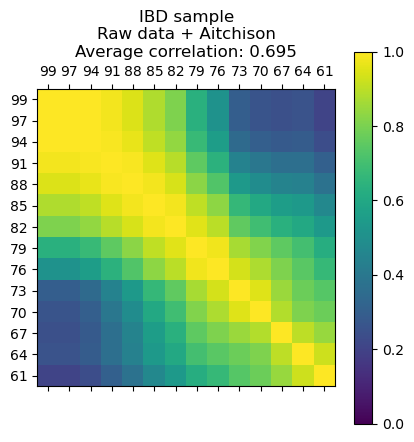

In [10]:
plt.matshow(corrs_nonembed, vmin=0, vmax=1)
plt.xticks(range(len(CUTOFFS)), CUTOFFS)
plt.yticks(range(len(CUTOFFS)), CUTOFFS)
plt.colorbar()
plt.title(f"{DATASET.upper()} sample\nRaw data + Aitchison\nAverage correlation: {np.mean(corrs_nonembed):.3f}")

Text(0.5, 1.0, 'IBD sample\n128-dimensional hyperbolic embedding\nAverage correlation: 0.760')

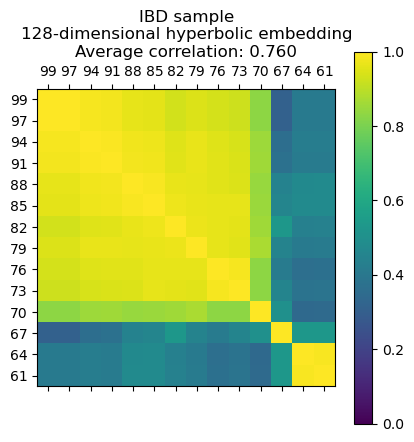

In [11]:
plt.matshow(corrs_embed, vmin=0, vmax=1)
plt.xticks(range(len(CUTOFFS)), CUTOFFS)
plt.yticks(range(len(CUTOFFS)), CUTOFFS)
plt.colorbar()
plt.title(f"{DATASET.upper()} sample\n{EMBED_DIM}-dimensional hyperbolic embedding\nAverage correlation: {np.mean(corrs_embed):.3f}")

Text(0.5, 1.0, 'IBD sample\nRaw data, top 16 PCs\nAverage correlation: 0.727')

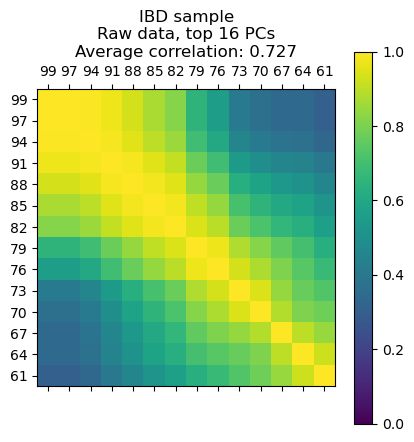

In [12]:
plt.matshow(corrs_pca, vmin=0, vmax=1)
plt.xticks(range(len(CUTOFFS)), CUTOFFS)
plt.yticks(range(len(CUTOFFS)), CUTOFFS)
plt.colorbar()
plt.title(f"{DATASET.upper()} sample\nRaw data, top 16 PCs\nAverage correlation: {np.mean(corrs_pca):.3f}")

Text(0.5, 1.0, 'IBD sample\n128-dimensional hyperbolic embedding + euclidean distance\nAverage correlation: 0.727')

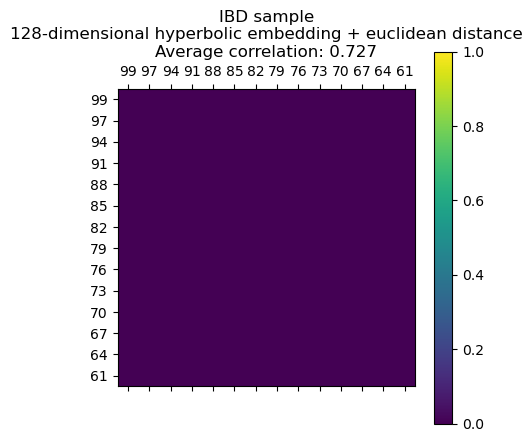

In [13]:
plt.matshow(corrs_embed_euc, vmin=0, vmax=1)
plt.xticks(range(len(CUTOFFS)), CUTOFFS)
plt.yticks(range(len(CUTOFFS)), CUTOFFS)
plt.colorbar()
plt.title(f"{DATASET.upper()} sample\n{EMBED_DIM}-dimensional hyperbolic embedding + euclidean distance\nAverage correlation: {np.mean(corrs_pca):.3f}")

In [14]:
print(corrs_nonembed.mean(), corrs_embed.mean(), corrs_pca.mean())

0.6953441265050364 0.7603021336986606 0.7268097214245217


ValueError: x, y, and format string must not be None

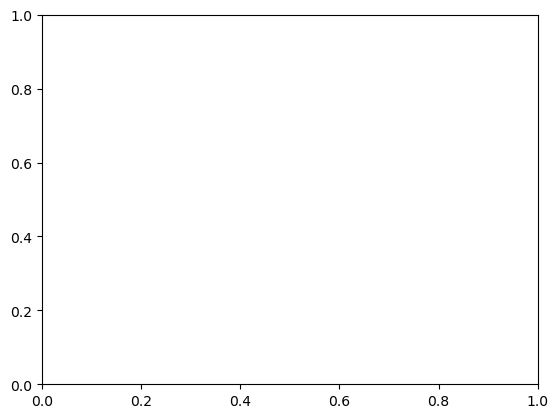

In [15]:
def get_corrs_sliding(corrs):
    out = []
    for i in range(1,len(corrs)):
        out.append(np.mean(corrs[:i, :i]))

plt.plot(get_corrs_sliding(corrs_nonembed), label="Raw data + Aitchison")

/tmp/ipykernel_275192/4270070046.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([""])


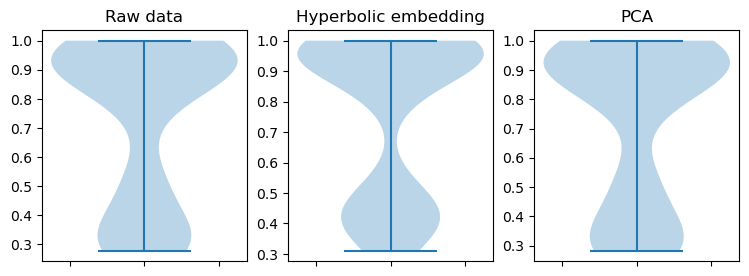

In [ ]:
# Make a violin plot of pairwise distances

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

to_plot = [corrs_nonembed, corrs_embed, corrs_pca]
titles = ["Raw data", "Hyperbolic embedding", "PCA"]

for i in range(3):
    # axs[i].boxplot(to_plot[i].flatten())
    axs[i].violinplot(to_plot[i].flatten())
    axs[i].set_title(titles[i])
    axs[i].set_xticklabels([""])

/tmp/ipykernel_275192/2242282506.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(cutoffs)


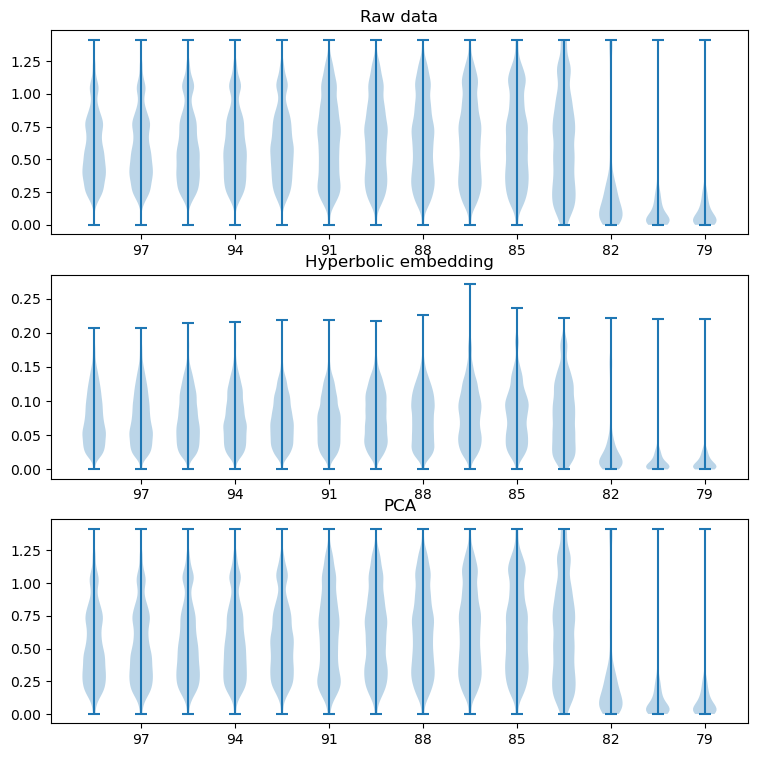

In [ ]:
# Plot the actual distributions of distances

fig, axs = plt.subplots(3, 1, figsize=(9, 9))

for i, data in enumerate([dists, embed_dists, pca_dists]):
    to_plot = [data["ibd"][x].flatten() for x in cutoffs]
    axs[i].violinplot(to_plot)
    axs[i].set_title(titles[i])
    axs[i].set_xticklabels(cutoffs)

In [ ]:
dists

{'ibd': {99: array([[0.        , 0.27539649, 0.30103074, ..., 0.68495109, 0.61756968,
          0.26556654],
         [0.27539649, 0.        , 0.15927699, ..., 0.60925276, 0.53389004,
          0.28052704],
         [0.30103074, 0.15927699, 0.        , ..., 0.61183953, 0.53778524,
          0.29459594],
         ...,
         [0.68495109, 0.60925276, 0.61183953, ..., 0.        , 0.45239945,
          0.51319063],
         [0.61756968, 0.53389004, 0.53778524, ..., 0.45239945, 0.        ,
          0.41664737],
         [0.26556654, 0.28052704, 0.29459594, ..., 0.51319063, 0.41664737,
          0.        ]]),
  97: array([[0.        , 0.27539649, 0.30103074, ..., 0.68495109, 0.61756968,
          0.26556654],
         [0.27539649, 0.        , 0.15927699, ..., 0.60925276, 0.53389004,
          0.28052704],
         [0.30103074, 0.15927699, 0.        , ..., 0.61183953, 0.53778524,
          0.29459594],
         ...,
         [0.68495109, 0.60925276, 0.61183953, ..., 0.        , 0.45239945